# 08.2 Log Bits

Same thing as in 8.1, except instead of a $\exp(x)$ activation on the random bits, its a $\log(x^2)$ activation.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
%cd drive/My\ Drive/CS281\ Final\ Project

## Package Loading

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from random import shuffle
import numpy as np
from sklearn.model_selection import train_test_split
device = 'cuda'

from math import isclose
from time import time
import pickle
import sys

## Manual Counter Implementation

In [0]:
def morris_count(seq):
    '''seq[:,0] is the sequence. seq[:,1] is the random floats.'''
    x = 0
    for i in seq:
        if i[0] == 1 and i[1]*(2**x)<=1:
            x += 1
    return x

## Model Definition

In [0]:
class Counter():
    def __init__(self, hidden):
        '''hidden is the number of hidden variables to use per cell'''
        self.hidden = hidden

        self.bits_lstm = nn.LSTM(hidden_size=hidden, batch_first=True, input_size=1).double().cuda() 
        self.bits_dense = torch.randn([hidden,1], dtype=float, device=device, requires_grad=True) 
        self.string_lstm = nn.LSTM(hidden_size=hidden, batch_first=True, input_size=2).double().cuda() 
        self.string_dense = torch.randn([hidden,1], dtype=float, device=device, requires_grad=True) 

        params = list(self.bits_lstm.parameters()) + list(self.string_lstm.parameters())
        params.append(self.bits_dense)
        params.append(self.string_dense)
        self.optimizer = optim.Adam(params)

    @staticmethod
    def convert_sequence(seq):
        '''converts a set of sequences with the same length from array or numpy into a correctly formatted tensor.'''
        seq = torch.tensor(seq, device=device).double()
        seq = seq.reshape([len(seq), -1, 1])
        return seq

    def predict(self, sequence):
        '''takes a tensor, predicts the sum of the tensor, and compares to the target sum of the tensor. 
        Returns the loss and the predicted sum'''

        floats = torch.rand_like(sequence)
        bits,_ = self.bits_lstm(floats)
        bits = bits @ self.bits_dense
        bits = torch.log(bits**2)
        combined = torch.cat([sequence, bits],2)
        out, _ = self.string_lstm(combined)
        add = torch.sigmoid(out @ self.string_dense)
        count = add.sum(1).squeeze(1)

        sequence = torch.cat([sequence, floats], 2)
        target = self.true_sum(sequence)
        loss = (count - target).pow(2)
        return loss, count

    def predict_multilength(self, sequences):
        '''Takes a list of batches of tensors of different length. Predicts on each batch. Sums up the loss. Reduces to a single mean'''
        loss = torch.tensor(0, device=device).double()
        count= torch.tensor(0, device=device).double()
        for s in sequences:
            res    = self.predict(s)[0]
            count += res.shape[0]
            loss  += res.sum()
        return loss / count

    @staticmethod
    def true_sum(sequence):
        '''Determines the true sums of a batch of sequences to train against'''
        res = []
        for seq in sequence:
            res.append(morris_count(seq))
        res = np.array(res, dtype=float)
        return torch.tensor(res, device=device).double()

## Data Generation

In [0]:
def round_partition(p):
    '''Rounds a partition so that the sum of the partition equals the original sum'''
    rounded = np.round(p).astype(int)
    ind = len(rounded)-1
    while rounded.sum() < p.sum():
        rounded[ind] += 1
        ind -= 1
    return rounded

def generate_data(length, total):
    counts = np.random.dirichlet((np.arange(length)+1)**2) * total * 0.9
    counts = round_partition(counts)

    train_set = []
    val_set = []
    test_set = []
    for i in range(1,length+1):
        if counts[i-1] == 0:
            continue
        seqs = np.random.randint(0,2, size=[counts[i-1],i])
        seqs = np.unique(seqs, axis=0)[:,:,None]
        try:
            train, val = train_test_split(seqs, test_size=2/9, shuffle=True)
            train = Counter.convert_sequence(train)
            val = Counter.convert_sequence(val)
            train_set.append(train)
            val_set.append(val)
        except ValueError:
            train = Counter.convert_sequence(seqs)
            train_set.append(train)
            continue
    counts = np.random.dirichlet((np.arange(length, 2*length)+1)**2) * total * 0.1
    counts = round_partition(counts)

    for i in range(length):
        if counts[i] == 0:
            continue
        seqs = np.random.randint(0,2, size=[counts[i],i+length+1])
        seqs = np.unique(seqs, axis=0)[:,:,None]
        seqs = Counter.convert_sequence(seqs)
        test_set.append(seqs)

    return train_set, val_set, test_set


In [0]:
#generate all the strings and partition into train and test
length = 64
hidden = 10
depth = 100

output_folder = "Part-8.2-Outputs"

In [0]:
# train, val, test = generate_data(length,depth)

# with open("%s/Data.pickle"%output_folder, "wb") as f:
#     pickle.dump([train, val, test], f)

In [0]:
with open("%s/Data.pickle"%output_folder, "rb") as f:
    train, val, test = pickle.load(f)

In [0]:
trainsize = sum([x.shape[0] for x in train])
valsize = sum([x.shape[0] for x in val])
testsize = sum([x.shape[0] for x in test])
print(trainsize, valsize, testsize)

total = trainsize+valsize+testsize
print("Total:",total) 
print("Fraction %.3f %.3f %.3f"%(trainsize/total, valsize/total, testsize/total))

print("Train    string range: %d-%d"%(min([x.shape[1] for x in train]), max([x.shape[1] for x in train])))
print("Validate string range: %d-%d"%(min([x.shape[1] for x in val]), max([x.shape[1] for x in val])))
print("Test     string range: %d-%d"%(min([x.shape[1] for x in test]), max([x.shape[1] for x in test])))

62 29 10
Total: 101
Fraction 0.614 0.287 0.099
Train    string range: 23-64
Validate string range: 39-64
Test     string range: 119-128


## Model Training

In [0]:
#train over all the training data
model = Counter(hidden=hidden)

history = []
best = float('inf')
patience = 10
tol = 0.001
count = 0

start = time()
for epoch in range(1,1000000): 
    shuffle(train)
    shuffle(val)
    if epoch % 100 == 0:
        train_loss = model.predict_multilength(train).item()
        with torch.no_grad():
            val_loss = model.predict_multilength(val).item()
        history.append([train_loss, val_loss])
        print("Epoch: %5d. Train Loss: %7.3f. Validation Loss: %7.3f. Elapsed: %7.3f"%(epoch, train_loss, val_loss, (time()-start)/60))
        start = time()

        if val_loss + tol < best:
            best = val_loss
            count = 0
            torch.save(model, "%s/Model"%output_folder)
        else:
            count += 1
        if count >= patience:
            break

    #take the average loss over all the train data
    loss = model.predict_multilength(train)   
    #and update
    model.optimizer.zero_grad()
    loss.backward(retain_graph=True)
    model.optimizer.step()

# history = np.array(history)
# np.save("%s/Train-History"%output_folder, history)
# torch.save(model, "%s/Model"%output_folder)

# #display testing results
# loss = model.predict_multilength(test)
# print("Average Test Loss:", loss.item())

## Results Evaluation

Same deal as in last time. 

In [0]:
model = torch.load("%s/Model"%output_folder)

In [0]:
loss = model.predict_multilength(train)
print("Average Train Loss:", loss.item())
loss = model.predict_multilength(val)
print("Average Val   Loss:", loss.item())
loss = model.predict_multilength(test)
print("Average Test  Loss:", loss.item())

Average Train Loss: 0.6621275245173541
Average Val   Loss: 0.40246617236868704
Average Test  Loss: 2.0435234672654277


In [0]:
loss = []
pred = []
size = []

In [0]:
for length in range(1000,10000,1000):
    depth = np.random.randint(1,10)
    seq = np.random.randint(0,2,size=(depth,length,1))
    seq = torch.tensor(seq).double().cuda()
    l,p = model.predict(seq)
    l = l.tolist()
    p = p.tolist()
    loss.extend(l)
    pred.extend(p)
    size.extend([length for _ in p])

In [0]:
true = []
for l,p in zip(loss,pred):
    t = p - np.sqrt(l)
    if not isclose(t, int(t)):
        t = p + np.sqrt(l)
    true.append(t)

In [0]:
res = pd.DataFrame({"Predicted":pred, "Loss":loss, "Length":size, "Real":true})
res.to_csv("%s/Large_testing-8.2"%output_folder)

In [0]:
res = pd.read_csv("%s/Large_testing-8.2"%output_folder)
res

,Unnamed: 0,Predicted,Loss,Length,Real
0,0,0.919267,0.006518,2,1.0
1,1,0.921876,0.006103,2,1.0
2,2,0.938727,0.003754,2,1.0
3,3,0.928309,0.005140,2,1.0
4,4,0.964871,0.001234,2,1.0
...,...,...,...,...,...
682,682,279.316328,70924.386353,9000,13.0
683,683,280.397408,72037.168505,9000,12.0
684,684,279.052613,71317.097988,9000,12.0
685,685,282.923385,73942.327367,9000,11.0


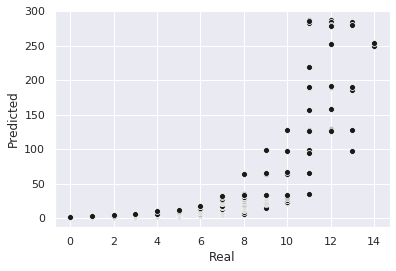

In [0]:
sns.set()
sns.scatterplot(x="Real", y="Predicted", data=res, color='k')
